# Paths

In [ ]:
data_path = "./data"


# Configurations

In [ ]:
img_dim = 256
nb_neighbors = 5
batch_size = 32
kernel = 3
channel = 3
epochs = 10000
patience = 50
num_classes = 313
kernel = 3
weight_decay = 1e-3
epsilon = 1e-8
# temperature parameter T
T = 0.38

# Imports

In [3]:
import os
import numpy as np
import glob
from random import randint, shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
import cv2 as cv
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.regularizers import l2
from keras.utils import plot_model
import sklearn.neighbors as nn


Using TensorFlow backend.


# utils


## show img by path/img

In [4]:
def show_img_path(path):
    img=mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [6]:
def show_img(img):
    imgplot = plt.imshow(img)
    plt.show()

## RGB to LAB

In [7]:
def rgb_to_lab(img):
    return  cv.cvtColor(img, cv.COLOR_BGR2LAB)
#     return color.rgb2lab(img)

## soft encoding

In [8]:
def get_soft_encoding(image_ab, nn_finder, nb_q):
    h, w = image_ab.shape[:2]
    a = np.ravel(image_ab[:, :, 0])
    b = np.ravel(image_ab[:, :, 1])
    ab = np.vstack((a, b)).T
    # Get the distance to and the idx of the nearest neighbors
    dist_neighb, idx_neigh = nn_finder.kneighbors(ab)
    # Smooth the weights with a gaussian kernel
    sigma_neighbor = 5
    wts = np.exp(-dist_neighb ** 2 / (2 * sigma_neighbor ** 2))
    wts = wts / np.sum(wts, axis=1)[:, np.newaxis]
    # format the tar get
    y = np.zeros((ab.shape[0], nb_q))
    idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
    y[idx_pts, idx_neigh] = wts
    y = y.reshape(h, w, nb_q)
    return y

# Loading data

In [9]:
list_imgs = glob.glob(data_path + "/*")
data_size = len(list_imgs)
print("Data size = " + str(data_size))
# suffle dataset
shuffle(list_imgs)


Data size = 2039


## Preview sample data

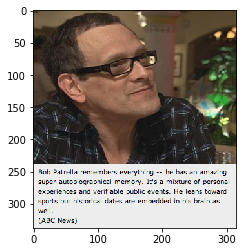

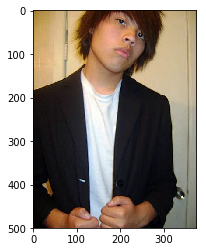

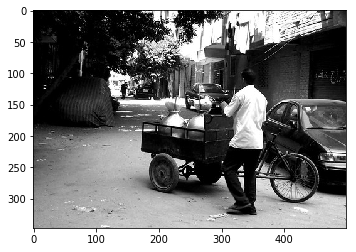

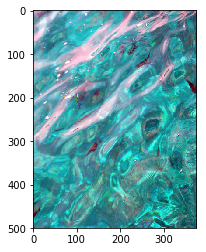

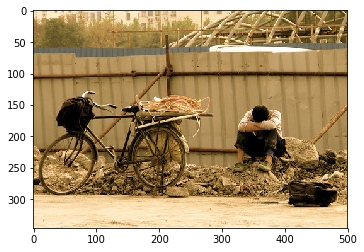

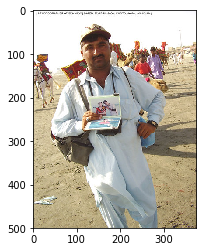

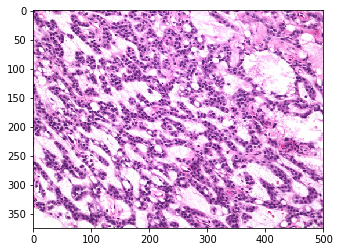

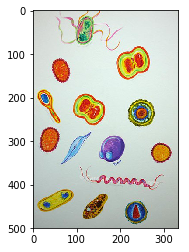

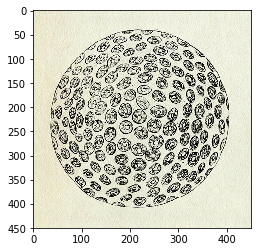

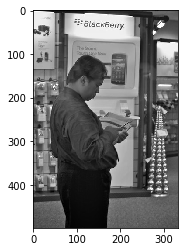

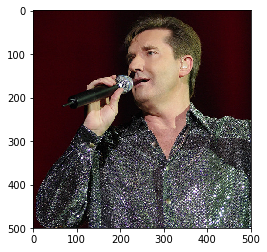

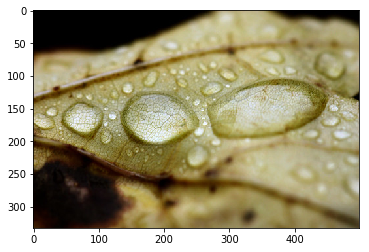

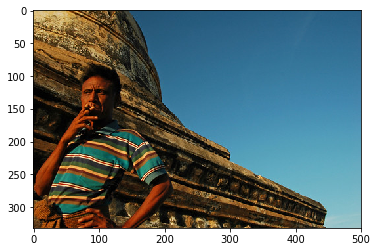

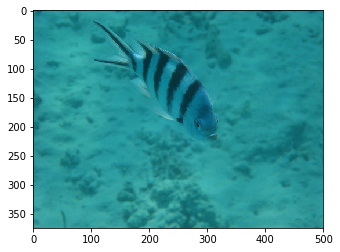

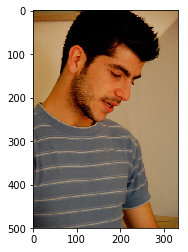

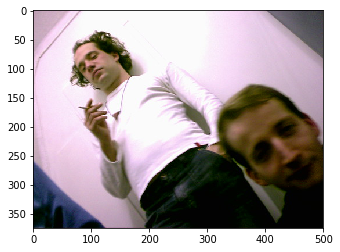

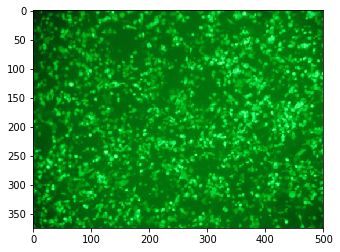

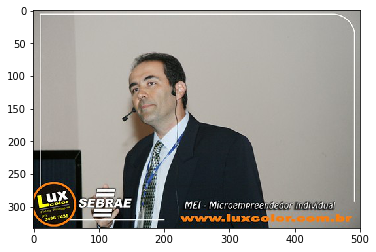

In [10]:
num_to_sample = 20
for i in range(num_to_sample):
    try:
        index = randint(0, data_size-1)
        img = list_imgs[index]
        show_img_path(img)
    except:
        pass
        

## Find color distribution in dataset

## find size distribution in dataset

# Split data


In [11]:
split_val = 0.3
split_num = int(data_size*split_val)
x_img_val = list_imgs[0:split_num]
x_img_train = list_imgs[split_num:]

train_len = len(x_img_train)
test_len = len(x_img_val)

print("Training on {} example and validating on {} example"
      .format(train_len, test_len))

Training on 1428 example and validating on 611 example


# Generate batch

In [12]:
def get_batch(full_list, batch_size=batch_size):
    x = []
    y = []
    while len(x) < batch_size:
        try:
            img_index =  random.randint(0,data_size)
            img = list_imgs[img_index]
            rgb = cv.imread(img)
            lab_img = rgb_to_lab(rgb)
            out_lab = cv.resize(lab_img, (img_dim//4, img_dim//4), cv.INTER_CUBIC)
            out_ab = out_lab[:, :, 1:].astype(np.int32) - 128
            ab_enc = get_soft_encoding(out_ab, nn_finder, nb_q)
            l = cv.imread(img, 0)/255
            
            y.append(ab_enc)
            x.append(l)
        except:
            pass
    return x, y

# MODEL

## Build model

In [13]:
def build_model():
    l2_reg = l2(1e-3)
    input_tensor = Input(shape=(img_dim, img_dim, 1))
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(input_tensor)
    x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='conv1_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg, strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_1', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv2_2', kernel_initializer="he_normal",
               kernel_regularizer=l2_reg,
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv3_3', kernel_initializer="he_normal",
               strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='conv4_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv5_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', dilation_rate=2, name='conv6_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='conv7_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_1',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_2',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='conv8_3',
               kernel_initializer="he_normal", kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same', name='pred')(x)

    model = Model(inputs=input_tensor, outputs=outputs, name="ColorNet")
    return model


## Call model


In [15]:
model = build_model()
print(model.summary())
plot_model(model, to_file='output/model/model.svg', show_layer_names=True, show_shapes=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 128)       512       
__________